In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
from tqdm.auto import tqdm

### Data description

**Constants Folder** - this folder contains the constants of the game, such as ability, hero, and item Ids and stats as of 21-Jan-2023

**Images Folder** - this folder contains images of the abilities, heroes, and items as of 28-Jan-2023

**YYYYMM (Matches) Folder** - this folder contains the details of the matches for league matches for a month and year

**all_word_counts.csv** - count of chat tokens ("gg" ,"go" , "glhf" , etc)

**chat.csv** - chats per match

**cosmetics.csv** - cosmetics of the heroes of the players per match

**draft_timings.csv** - contains draft details per match

**main_metadata.csv** - the main csv file, everything connects from here

**objectives.csv** - contains objectives or milestones in a match, FIRSTBLOOD, BARRACKS down, etc

**picks_bans.csv** - the draft phase, where opposing teams ban and pick heroes.

**players.csv** - players' heroes and actions

**radiant_exp_adv.csv** - auto-calculated exp advantage per minute

**radiant_gold_adv.csv** - auto-calculated gold advantage per minute

**teamfights.csv** - contains teamfights per match

**teams.csv** - the opposing radiant and dire teams

In [2]:
import logging
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger(__name__)

In [3]:
RAW_DATA_FOLDER = f'data/raw'
PROCESSED_DATA_FOLDER = f'data/processed'
DATA_PARTITIONS = [f'2024{i:02}' for i in range(5, 11)]
# DATA_PARTITIONS = [f'2024{i:02}' for i in range(8, 10)]
print(DATA_PARTITIONS)

['202405', '202406', '202407', '202408', '202409', '202410']


In [4]:
METADATA_COLUMNS = [
    'match_id', 'duration', 'first_blood_time',
    'radiant_win', 'start_date_time',
]
PLAYERS_COLUMNS = [
    'match_id',
    'player_slot',
    'buyback_log',
    'dn_t',
    'firstblood_claimed',
    'gold_t',
    'kills_log',
    'lh_t',
    'obs_left_log',
    'obs_log',
    'party_size',
    'purchase_log',
    'runes_log',
    'sen_left_log',
    'sen_log',
    'times',
    'xp_t',

]

OBJECTIVES_COLUMNS = [
    'match_id', 'player_slot', 'team', 'type', 'key', 'value', 'time', 'slot', 'killer', 'unit', 'leagueid'
]

RADIANT_EXP_ADV_COLUMNS = [
    'minute', 'exp', 'match_id'
]

RADIANT_GOLD_ADV_COLUMNS = [
    'minute', 'gold', 'match_id'
]

TEAMFIGTHS_COLUMNS = [
    'start', 'end', 'last_death', 'deaths', 'players', 'match_id'
]


In [5]:
class RawDataset:
    def __init__(self, partitions):
        self.partitions = partitions
        logger.info(f'Loading data for partitions: {partitions}')

        logger.info('Loading main metadata...')
        self.main_metadata = self._read_df_by_partitions('main_metadata', partitions, columns=METADATA_COLUMNS)

        logger.info('Loading main players...')
        self.players = self._read_df_by_partitions('players', partitions, columns=PLAYERS_COLUMNS)

        # logger.info('Loading teams...')
        # self.teams = self._read_df_by_partitions('teams', partitions)

        logger.info('Loading objectives...')
        self.objectives = self._read_df_by_partitions('objectives', partitions, columns=OBJECTIVES_COLUMNS)

        logger.info('Loading radiant_gold_adv...')
        self.radiant_gold_adv = self._read_df_by_partitions('radiant_gold_adv', partitions, columns=RADIANT_GOLD_ADV_COLUMNS)

        logger.info('Loading radiant_exp_adv...')
        self.radiant_exp_adv = self._read_df_by_partitions('radiant_exp_adv', partitions, columns=RADIANT_EXP_ADV_COLUMNS)

        logger.info('Loading teamfights...')
        self.teamfights = self._read_df_by_partitions('teamfights', partitions, columns=TEAMFIGTHS_COLUMNS)
        
    
    def _read_df_by_partitions(self, df_name, partitions, columns=None):
        dfs = []
        for partition in tqdm(partitions, desc=f'Reading {df_name:20}'):
            df = pd.read_csv(f'{RAW_DATA_FOLDER}/{partition}/{df_name}.csv', low_memory=False)
            if columns is None:
                columns = df.columns
            df = df[columns]
            dfs.append(df)
        return pd.concat(dfs).reset_index(drop=True)

In [6]:
raw_dataset = RawDataset(DATA_PARTITIONS)

INFO:__main__:Loading data for partitions: ['202405', '202406', '202407', '202408', '202409', '202410']
INFO:__main__:Loading main metadata...


Reading main_metadata       :   0%|          | 0/6 [00:00<?, ?it/s]

INFO:__main__:Loading main players...


Reading players             :   0%|          | 0/6 [00:00<?, ?it/s]

INFO:__main__:Loading objectives...


Reading objectives          :   0%|          | 0/6 [00:00<?, ?it/s]

INFO:__main__:Loading radiant_gold_adv...


Reading radiant_gold_adv    :   0%|          | 0/6 [00:00<?, ?it/s]

INFO:__main__:Loading radiant_exp_adv...


Reading radiant_exp_adv     :   0%|          | 0/6 [00:00<?, ?it/s]

INFO:__main__:Loading teamfights...


Reading teamfights          :   0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
raw_dataset.main_metadata

,match_id,duration,first_blood_time,radiant_win,start_date_time
0,7714381774,1992,50,True,2024-05-01 00:06:27
1,7714412554,1284,147,True,2024-05-01 00:50:43
2,7714827417,2019,92,False,2024-05-01 08:06:57
3,7714833927,1749,197,False,2024-05-01 08:11:41
4,7714860593,1588,443,True,2024-05-01 08:30:08
...,...,...,...,...,...
13817,8007559716,1843,193,True,2024-10-27 20:46:07
13818,8007625072,1962,113,True,2024-10-27 21:50:07
13819,8007663769,1690,47,True,2024-10-27 22:36:21
13820,8007693639,1991,175,False,2024-10-27 23:20:35


In [8]:
raw_dataset.players.head()

,match_id,player_slot,buyback_log,dn_t,firstblood_claimed,gold_t,kills_log,lh_t,obs_left_log,obs_log,party_size,purchase_log,runes_log,sen_left_log,sen_log,times,xp_t
0,7714381774,0,"[{'time': 1720, 'slot': 0, 'type': 'buyback_lo...","[0, 0, 1, 3, 4, 4, 5, 8, 9, 9, 9, 9, 9, 9, 9, ...",0.0,"[0, 204, 486, 727, 968, 1267, 2044, 2381, 2720...","[{'time': 482, 'key': 'npc_dota_hero_disruptor...","[0, 1, 6, 10, 13, 18, 26, 30, 35, 41, 49, 52, ...",[],[],10.0,"[{'time': -89, 'key': 'quelling_blade'}, {'tim...","[{'time': 0, 'key': 5}, {'time': 1482, 'key': 8}]",[],[],"[0, 60, 120, 180, 240, 300, 360, 420, 480, 540...","[0, 28, 281, 461, 592, 1010, 1388, 1753, 2111,..."
1,7714381774,1,[],"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, ...",0.0,"[0, 170, 310, 448, 676, 826, 1023, 1663, 1784,...","[{'time': 383, 'key': 'npc_dota_hero_enigma'},...","[0, 0, 1, 1, 3, 4, 6, 7, 9, 12, 13, 15, 15, 17...","[{'time': 319, 'type': 'obs_left_log', 'key': ...","[{'time': -41, 'type': 'obs_log', 'key': '[158...",10.0,"[{'time': -89, 'key': 'tango', 'charges': 6}, ...","[{'time': 912, 'key': 5}, {'time': 963, 'key':...","[{'time': 512, 'type': 'sen_left_log', 'key': ...","[{'time': 92, 'type': 'sen_log', 'key': '[164,...","[0, 60, 120, 180, 240, 300, 360, 420, 480, 540...","[0, 118, 281, 567, 803, 1006, 1267, 1776, 1796..."
2,7714381774,2,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[0, 244, 607, 951, 1368, 1813, 2292, 2907, 347...","[{'time': 389, 'key': 'npc_dota_hero_techies'}...","[0, 2, 9, 14, 21, 31, 39, 46, 67, 81, 88, 102,...","[{'time': 304, 'type': 'obs_left_log', 'key': ...","[{'time': -56, 'type': 'obs_log', 'key': '[124...",10.0,"[{'time': -84, 'key': 'ward_observer'}, {'time...","[{'time': 170, 'key': 7}, {'time': 357, 'key':...",[],[],"[0, 60, 120, 180, 240, 300, 360, 420, 480, 540...","[0, 297, 777, 1200, 1680, 2103, 2614, 3058, 39..."
3,7714381774,3,"[{'time': 1713, 'slot': 3, 'type': 'buyback_lo...","[0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, ...",0.0,"[0, 170, 260, 396, 531, 621, 1074, 1290, 1425,...","[{'time': 1266, 'key': 'npc_dota_hero_storm_sp...","[0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 5, 9, 9, 10,...","[{'time': 1251, 'type': 'obs_left_log', 'key':...","[{'time': 965, 'type': 'obs_log', 'key': '[142...",10.0,"[{'time': -77, 'key': 'tango'}, {'time': -77, ...",[],"[{'time': 694, 'type': 'sen_left_log', 'key': ...","[{'time': 273, 'type': 'sen_log', 'key': '[98,...","[0, 60, 120, 180, 240, 300, 360, 420, 480, 540...","[0, 85, 303, 455, 567, 717, 1416, 1617, 1735, ..."
4,7714381774,4,"[{'time': 1706, 'slot': 4, 'type': 'buyback_lo...","[0, 0, 0, 0, 1, 1, 3, 5, 5, 5, 6, 6, 6, 6, 6, ...",0.0,"[0, 243, 552, 993, 1308, 1709, 2124, 2921, 335...","[{'time': 731, 'key': 'npc_dota_hero_enigma'},...","[0, 2, 8, 16, 21, 28, 37, 47, 55, 59, 69, 79, ...",[],[],10.0,"[{'time': -56, 'key': 'tango'}, {'time': -55, ...","[{'time': 0, 'key': 5}, {'time': 890, 'key': 8}]",[],[],"[0, 60, 120, 180, 240, 300, 360, 420, 480, 540...","[0, 118, 395, 622, 858, 1175, 1436, 2002, 2499..."


In [9]:
raw_dataset.objectives.head()

,match_id,player_slot,team,type,key,value,time,slot,killer,unit,leagueid
0,7714381774,131.0,NaN,CHAT_MESSAGE_FIRSTBLOOD,0,NaN,50.0,8.0,NaN,NaN,16109
1,7714381774,0.0,NaN,building_kill,npc_dota_badguys_tower1_top,NaN,853.0,0.0,NaN,npc_dota_hero_bristleback,16109
2,7714381774,129.0,NaN,building_kill,npc_dota_goodguys_tower1_bot,NaN,884.0,6.0,NaN,npc_dota_hero_techies,16109
3,7714381774,2.0,NaN,building_kill,npc_dota_badguys_tower1_mid,NaN,1117.0,2.0,NaN,npc_dota_hero_puck,16109
4,7714381774,131.0,NaN,building_kill,npc_dota_goodguys_tower2_bot,NaN,1297.0,8.0,NaN,npc_dota_hero_luna,16109


In [10]:
raw_dataset.radiant_exp_adv.head()

,minute,exp,match_id
0,1,0.0,7714381774
1,2,102.0,7714381774
2,3,-387.0,7714381774
3,4,-585.0,7714381774
4,5,-1141.0,7714381774


In [11]:
raw_dataset.teamfights.head()

,start,end,last_death,deaths,players,match_id
0,464.0,499.0,484.0,3.0,"[{'deaths_pos': {'94': {'162': 1}}, 'ability_u...",7714381774
1,780.0,821.0,806.0,3.0,"[{'deaths_pos': {}, 'ability_uses': {'bristleb...",7714381774
2,1067.0,1123.0,1108.0,4.0,"[{'deaths_pos': {}, 'ability_uses': {'bristleb...",7714381774
3,1171.0,1210.0,1195.0,4.0,"[{'deaths_pos': {'102': {'172': 1}}, 'ability_...",7714381774
4,1248.0,1285.0,1270.0,3.0,"[{'deaths_pos': {}, 'ability_uses': {'bristleb...",7714381774


In [12]:
# Будем предсказывать победу команды radiant по данным матча на момент 20й минуты
TIME = 20 * 60

In [95]:
def parse_list(x):
    if isinstance(x, str):
        return json.loads(x.replace("'", '"').replace('True', 'true').replace('False', 'false'))
    if isinstance(x, list):
        return x
    return []


def get_log_data_at_time(x, time):
    result = []
    for log in x:
        if log['time'] <= time:
            result.append(log)
    return result

def count_handler(x):
    return len(x)

def keyed_count_handler(x):
    counts = {}
    for log in x:
        key = log['key']
        counts[key] = counts.get(key, 0) + 1
        return counts

class ParsedDataset:
    def __init__(self, raw_dataset):
        self._raw_dataset = raw_dataset
        self._parse()
    
    def _parse(self):
        self._filter_matches()
        self._get_data_at_time(TIME)
        self._merge_data()

    def _filter_matches(self):
        # Удалим матчи, которые длились меньще 30 минут
        logger.info(f'Filter matches with duration < 30 minutes')
        matches = self._raw_dataset.main_metadata.query('duration >= 30*60')
        self.matches = matches
        logger.info(f'Filtered matches: {matches.shape[0]}')

    def _get_data_at_time(self, time):
        self._parse_matches(time)
        self._parse_players_data(time)
        self._parse_objectives_data(time)
        self._parse_radiant_adv_data(time)
        self._parse_teamfights_data(time)

    def _parse_matches(self, time):
        logger.info(f'Parsing matches data at time {time}')
        matches = self.matches.copy()
        matches['radiant_win'] = matches['radiant_win'].apply(lambda x: 1 if x else 0)
        matches['radiant_win'] = matches['radiant_win'].astype(int)
        matches['start_date_time'] = pd.to_datetime(matches['start_date_time'])
        matches['first_blood_time'] = matches['first_blood_time'].fillna(0)
        matches['first_blood_time'] = matches['first_blood_time'].apply(lambda x: x if x <= time else 0)

        matches = matches.drop(columns=['duration'])
        self.matches = matches

    def _parse_players_data(self, time):
        logger.info(f'Parsing players data at time {time}')
        self.players = self._raw_dataset.players.copy()
        
        self._parse_players_t_columns(time)
        self._parse_players_log_columns(time)

    def _parse_players_t_columns(self, time):
        players = self.players

        t_columns = ['gold_t', 'xp_t', 'lh_t', 'dn_t']
        logger.info(f'Parsing t_columns: {t_columns} at time {time}')
        players['times'] = players['times'].apply(lambda x: parse_list(x))

        # Выкидываем игроков, которые не были в матче на момент времени time
        players = players[players['times'].apply(lambda x: time in x)].copy()

        # Ищем индекс времени 20й минуты
        players['t_index'] = players['times'].apply(lambda x: x.index(time))

        # Парсим данные по времени time
        for col in t_columns:
            players[col] = players[col].apply(lambda x: parse_list(x))
            players[f'{col}_{time}'] = players.apply(lambda x: x[col][x['t_index']], axis=1)


        players = players.drop(columns=['times', 't_index'] + t_columns)
        self.players = players
    
    def _parse_players_log_columns(self, time):
        players = self.players
        log_columns_handlers = {
            'kills_log':    ('count', count_handler),
            'buyback_log':  ('count', count_handler),
            'obs_log':      ('count', count_handler),
            'obs_left_log': ('count', count_handler),
            'sen_log':      ('count', count_handler),
            'purchase_log': ('count_{key}', keyed_count_handler),
            'runes_log':    ('count_{key}', keyed_count_handler),
            'sen_left_log': ('count', count_handler),
        }
        logger.info(f'Parsing log_columns: {log_columns_handlers.keys()} at time {time}')
    
        # Парсим данные по времени time
        for col, handler in log_columns_handlers.items():
            players[col] = players[col].apply(lambda x: parse_list(x))
            players[f'{col}_{time}'] = players.apply(lambda x: get_log_data_at_time(x[col], time), axis=1)
            handler_type, handler = handler
            res = players[f'{col}_{time}'].apply(handler)

            if handler_type == 'count':
                players[f'{col}_{time}'] = res.astype(int)
            else:
                keyed_counts = pd.json_normalize(res).fillna(0).astype(int)
                keyed_counts.columns = [f'{col}_{key}_{time}' for key in keyed_counts.columns]
                players = pd.concat([players.reset_index(drop=True), keyed_counts.reset_index(drop=True)], axis=1)
                    

        players = players.drop([col for col in log_columns_handlers.keys()] + [f"{col}_{time}" for col, handler in log_columns_handlers.items() if handler[0] != 'count'], axis=1)
        self.players = players

    def _parse_objectives_data(self, time):
        logger.info(f'Parsing objectives data at time {time}')
        objectives = self._raw_dataset.objectives.copy()
        objectives = objectives[objectives['time'] <= time]
        objectives = objectives.drop(columns=['time'])
        
        # TODO: добавить обработку objectives
        self.objectives = objectives
        
    def _parse_radiant_adv_data(self, time):
        logger.info(f'Parsing radiant_adv data at time {time}')
        radiant_gold_adv = self._raw_dataset.radiant_gold_adv.copy()
        radiant_exp_adv = self._raw_dataset.radiant_exp_adv.copy()

        radiant_gold_adv = radiant_gold_adv[radiant_gold_adv['minute'] * 60 <= time]
        radiant_exp_adv = radiant_exp_adv[radiant_exp_adv['minute'] * 60 <= time]

        # TODO: добавить обработку radiant_adv
        self.radiant_gold_adv = radiant_gold_adv
        self.radiant_exp_adv = radiant_exp_adv

    def _parse_teamfights_data(self, time):
        logger.info(f'Parsing teamfights data at time {time}')
        teamfights = self._raw_dataset.teamfights.copy()
        teamfights = teamfights[teamfights['end'] <= time]

        # TODO: добавить обработку teamfights
        self.teamfights = teamfights

    def _merge_data(self):
        logger.info(f'Merging data')

        logger.info('Transform players data to wide format')
        self.players_wide = self.players.pivot_table(
            index=['match_id'],
            columns='player_slot',
            values=self.players.columns
        ).reset_index()
        self.players_wide.columns = [f"{col[0]}_{col[1]}" for col in self.players_wide.columns]
        self.players_wide = self.players_wide.rename(columns={'match_id_': 'match_id'})

        self.data = self.matches.merge(self.players_wide, on='match_id', how='left')
        logger.info(f'Merged data shape: {self.data.shape}')


In [96]:
parsed_dataset = ParsedDataset(raw_dataset)

INFO:__main__:Filter matches with duration < 30 minutes
INFO:__main__:Filtered matches: 7657
INFO:__main__:Parsing matches data at time 1200
INFO:__main__:Parsing players data at time 1200
INFO:__main__:Parsing t_columns: ['gold_t', 'xp_t', 'lh_t', 'dn_t'] at time 1200
INFO:__main__:Parsing log_columns: dict_keys(['kills_log', 'buyback_log', 'obs_log', 'obs_left_log', 'sen_log', 'purchase_log', 'runes_log', 'sen_left_log']) at time 1200
INFO:__main__:Parsing objectives data at time 1200
INFO:__main__:Parsing radiant_adv data at time 1200
INFO:__main__:Parsing teamfights data at time 1200
INFO:__main__:Merging data
INFO:__main__:Transform players data to wide format
INFO:__main__:Merged data shape: (7657, 664)


In [100]:
class FeatureExtractor:
    def __init__(self, time):
        self.is_fitted = False
        self.time = time
    
    def fit(self):
        self.is_fitted = True

    def _add_sum_diff_features(self, data, feature_name):
        data[f'sum_{feature_name}_radiant_{self.time}'] = data[[f'{feature_name}_{self.time}_{player_slot}' for player_slot in [0, 1, 2, 3, 4]]].sum(axis=1)
        data[f'sum_{feature_name}_dire_{self.time}'] = data[[f'{feature_name}_{self.time}_{player_slot}' for player_slot in [128, 129, 130, 131, 132]]].sum(axis=1)
        data[f'sum_{feature_name}_diff_{self.time}'] = data[f'sum_{feature_name}_radiant_{self.time}'] - data[f'sum_{feature_name}_dire_{self.time}']

    def transform(self, data):
        if not self.is_fitted:
            raise Exception('FeatureExtractor is not fitted')
        data = data.copy()
        
        data[f'max_gold_player_radiant_slot_{self.time}'] = data[[f'gold_t_{self.time}_{player_slot}' for player_slot in [0, 1, 2, 3, 4]]].fillna(0).apply(lambda x: x.argmax(), axis=1).astype(int)
        data[f'max_gold_player_dire_slot_{self.time}'] = data[[f'gold_t_{self.time}_{player_slot}' for player_slot in [128, 129, 130, 131, 132]]].fillna(0).apply(lambda x: x.argmax(), axis=1).astype(int)

        data[f'max_gold_player_radiant_{self.time}'] = data.apply(lambda x: x[f'gold_t_{self.time}_{int(x[f"max_gold_player_radiant_slot_{self.time}"])}'], axis=1)
        data[f'max_gold_player_dire_{self.time}'] = data.apply(lambda x: x[f'gold_t_{self.time}_{int(x[f"max_gold_player_dire_slot_{self.time}"])}'], axis=1)

        data[f'max_gold_players_diff_{self.time}'] = data[f'max_gold_player_radiant_{self.time}'] - data[f'max_gold_player_dire_{self.time}']

        for column in ['gold_t', 'xp_t', 'lh_t', 'dn_t', 'kills_log', 'buyback_log', 'obs_log', 'obs_left_log', 'sen_log', 'sen_left_log']:
            self._add_sum_diff_features(data, column)

        # TODO: добавить фичи

        return data
    
    def fit_transform(self, data):
        self.fit()
        return self.transform(data)

In [101]:
from sklearn.model_selection import train_test_split

X = parsed_dataset.data.drop(['match_id', 'radiant_win', 'start_date_time'], axis=1)
y = parsed_dataset.data['radiant_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

feature_extractor = FeatureExtractor(TIME)

X_train = feature_extractor.fit_transform(X_train)
X_test = feature_extractor.transform(X_test)

# Описание полей в Dota 2 датасете

| Поле                                      | Тип       | Описание                                                                                         |
|-------------------------------------------|-----------|--------------------------------------------------------------------------------------------------|
| `match_id`                                | integer   | Уникальный идентификатор матча.                                                                        |
| `first_blood_time`                        | float64   | Время, когда произошло первое убийство (в секундах).                                                   |
| `buyback_log_{time}_{player_slot}`        | float64   | Количество выкупов на момент времени {time} у игрока {player_slot}                                     |
| `dn_t_{time}_{player_slot}`               | float64   | Количество добиваний союзных крипов на момент времени {time} у игрока {player_slot}                    |
| `lh_t_{time}_{player_slot}`               | float64   | Количество добиваний на момент времени {time} у игрока {player_slot}                                   |
| `kills_log_{time}_{player_slot}`          | float64   | Количество убийств на момент времени {time} у игрока {player_slot}                                     |
| `gold_t_{time}_{player_slot}`             | float64   | Количество золота на момент времени {time} у игрока {player_slot}                                      |
| `exp_t_{time}_{player_slot}`              | float64   | Количество опыта на момент времени {time} у игрока {player_slot}                                       |
| `party_size_{player_slot}`                | float64   | Размер команды игрока {player_slot}                                                                    |
| `purchase_log_{item}_{time}_{player_slot}`| float64   | Количество предметов {item}, купленных игроком {player_slot}, на момент времени {time}                 |
| `runes_log_{type}_{time}_{player_slot}`   | float64   | Количество рун типа {type}, подобранных игроком {player_slot}, на момент времени {time}                |
| `obs_log_{time}_{player_slot}`            | float64   | Количество Observer вардов, поставленных игроком {player_slot}, на момент времени {time}               |
| `sen_log_{time}_{player_slot}`            | float64   | Количество Sentry вардов, поставленных игроком {player_slot}, на момент времени {time}                 |
| `obs_left_log_{time}_{player_slot}`       | float64   | Количество Observer вардов, сломанных у игрока {player_slot}, на момент времени {time}                 |
| `sen_left_log_{time}_{player_slot}`       | float64   | Количество Sentry вардов, сломанных у игрока {player_slot}, на момент времени {time}                   |
| `max_gold_player_radiant_slot_{time}`     | float64   | Номер слота игрока в команде radiant с максимальным количеством золота на момент времени {time}        |
| `max_gold_player_dire_slot_{time}`        | float64   | Номер слота игрока в команде dire с максимальным количеством золота на момент времени {time}           |
| `max_gold_player_radiant_{time}`          | float64   | Количество золота игрока в команде radiant с максимальным количеством золота на момент времени {time}  |
| `max_gold_player_dire_{time}`             | float64   | Количество золота игрока в команде dire с максимальным количеством золота на момент времени {time}     |
| `max_gold_player_diff_{time}`             | float64   | Разница золота игроков с максимальным количеством золота на момент времени {time} в двух командах      |
| `sum_{feature}_radiant_{time}`            | float64   | Сумма значений признака {feature} у команды radiant на момент времени {time}                           |
| `sum_{feature}_dire_{time}`               | float64   | Сумма значений признака {feature} у команды dire на момент времени {time}                              |
| `sum_{feature}_diff_{time}`               | float64   | Разница сумм значений признака {feature} у команд radiant и dire на момент времени {time}              |
| `firstblood_claimed_{player_slot}`        | bool      | Совершил ли игрок {player_slot} первое убийство в матче                                                |









In [131]:
parsed_dataset.data.to_csv(f'{PROCESSED_DATA_FOLDER}/parsed_data.csv', index=False)

### EDA

In [132]:
import seaborn as sns

In [133]:
X_train.head()

,first_blood_time,buyback_log_1200_0,buyback_log_1200_1,buyback_log_1200_2,buyback_log_1200_3,buyback_log_1200_4,buyback_log_1200_128,buyback_log_1200_129,buyback_log_1200_130,buyback_log_1200_131,...,sum_obs_log_diff_1200,sum_obs_left_log_radiant_1200,sum_obs_left_log_dire_1200,sum_obs_left_log_diff_1200,sum_sen_log_radiant_1200,sum_sen_log_dire_1200,sum_sen_log_diff_1200,sum_sen_left_log_radiant_1200,sum_sen_left_log_dire_1200,sum_sen_left_log_diff_1200
0,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.0,4.0,7.0,-3.0,8.0,7.0,1.0,3.0,5.0,-2.0
1,92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,7.0,0.0,11.0,15.0,-4.0,7.0,11.0,-4.0
2,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,7.0,7.0,0.0,13.0,11.0,2.0,5.0,6.0,-1.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,9.0,-2.0,15.0,13.0,2.0,8.0,9.0,-1.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,8.0,8.0,0.0,15.0,13.0,2.0,12.0,9.0,3.0


In [134]:
X_train.isna().sum()

first_blood_time                 0
buyback_log_1200_0               0
buyback_log_1200_1               0
buyback_log_1200_2               0
buyback_log_1200_3               0
                                ..
sum_sen_log_dire_1200            0
sum_sen_log_diff_1200            0
sum_sen_left_log_radiant_1200    0
sum_sen_left_log_dire_1200       0
sum_sen_left_log_diff_1200       0
Length: 696, dtype: int64

In [135]:
X_train = X_train.fillna(0)

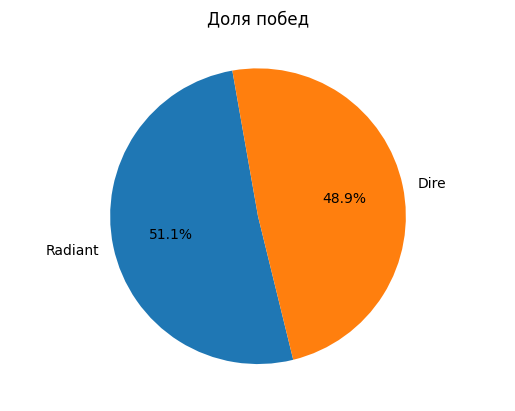

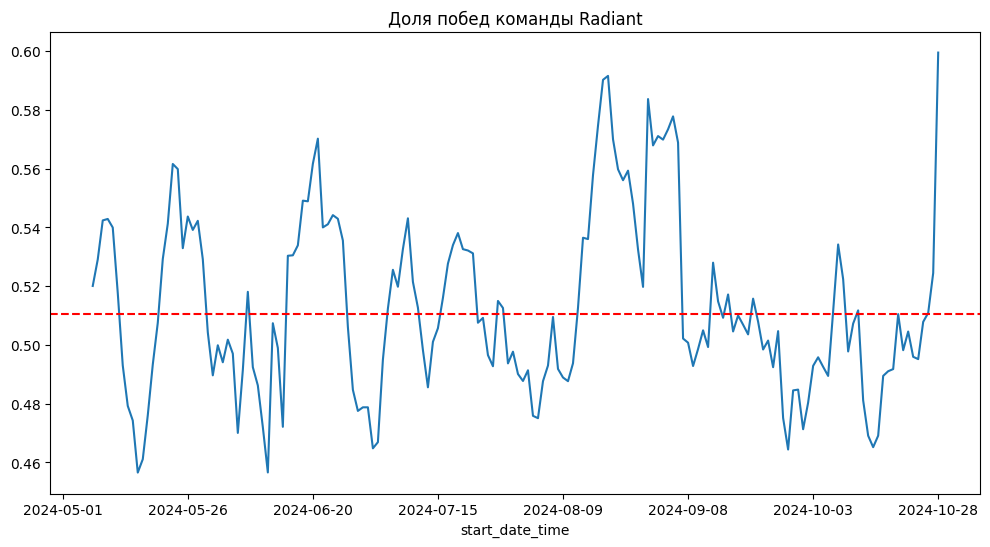

Оказывается, что доля побед команды Radiant меняется в зависимости от времени


In [188]:
# Посмотрим на долю побед команд
plt.title('Доля побед')
plt.axis('equal')
plt.pie(y_train.value_counts().values / y_train.shape[0], labels=['Radiant','Dire'], startangle=100, autopct='%.1f%%');
plt.show()

# Интересно, как она менялась со временем
plt.figure(figsize=(12, 6))

plt.title('Доля побед команды Radiant')

grouped = 1 - parsed_dataset.matches.groupby(parsed_dataset.matches['start_date_time'].dt.strftime('%Y-%m-%d'))['radiant_win'].mean()
grouped.rolling(window=7).mean().plot()
plt.axhline(1 - y_train.mean(), color='red', linestyle='--', label='Mean')
plt.show()

print('Оказывается, что доля побед команды Radiant меняется в зависимости от времени')


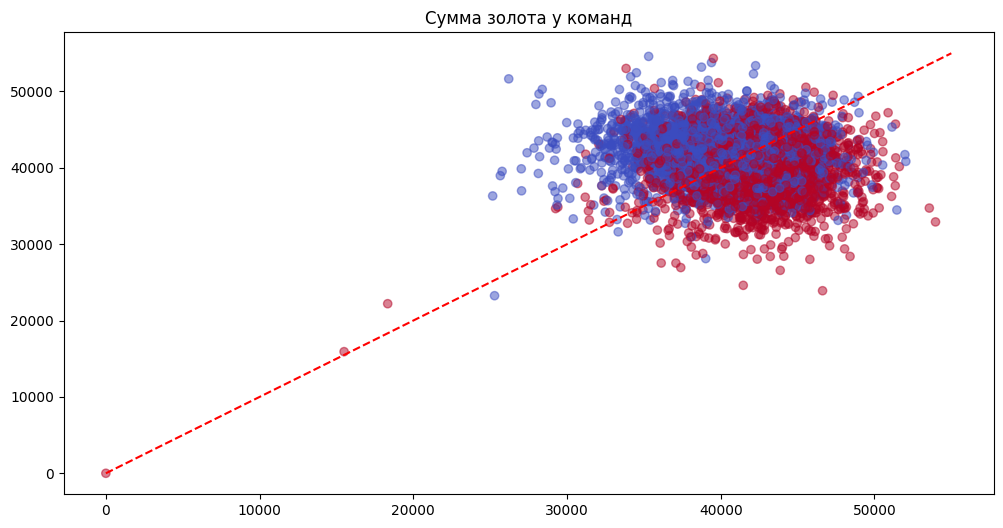

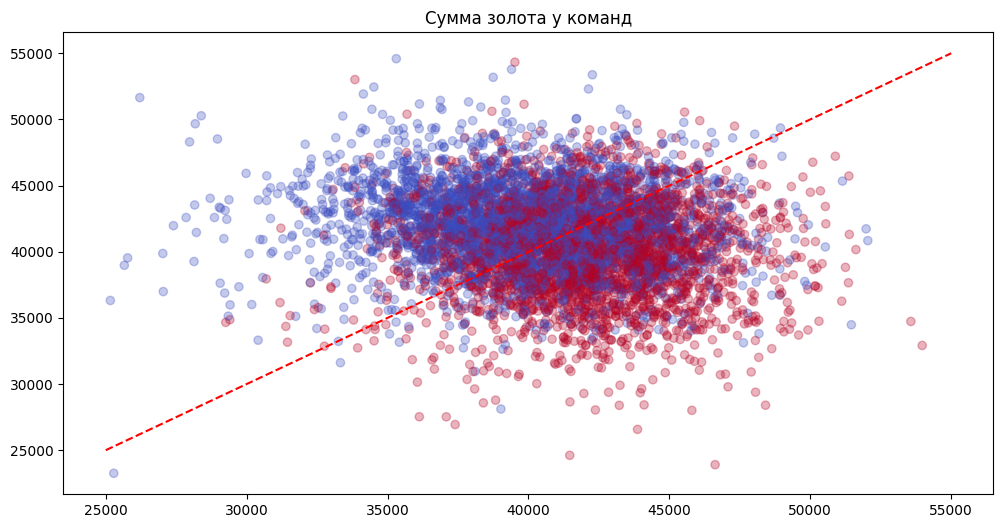

Видим, что классы хорошо разделяются по сумме золота


In [189]:
# Посмотрим на распределение суммы золота у команд

plt.figure(figsize=(12, 6))
plt.title('Сумма золота у команд')
plt.scatter(X_train['sum_gold_t_radiant_1200'], X_train['sum_gold_t_dire_1200'], c=y_train, cmap='coolwarm', alpha=0.5);
plt.plot([0, 55000], [0, 55000], color='red', linestyle='--', label='y=x')
plt.show()


plt.figure(figsize=(12, 6))
plt.title('Сумма золота у команд')
filtered = X_train[(X_train['sum_gold_t_radiant_1200'] > 20000) & (X_train['sum_gold_t_dire_1200'] > 20000)]
plt.scatter(filtered['sum_gold_t_radiant_1200'], filtered['sum_gold_t_dire_1200'], c=y_train.loc[filtered.index], cmap='coolwarm', alpha=0.3);
plt.plot([25000, 55000], [25000, 55000], color='red', linestyle='--', label='y=x')
plt.show()

print("Видим, что классы хорошо разделяются по сумме золота")


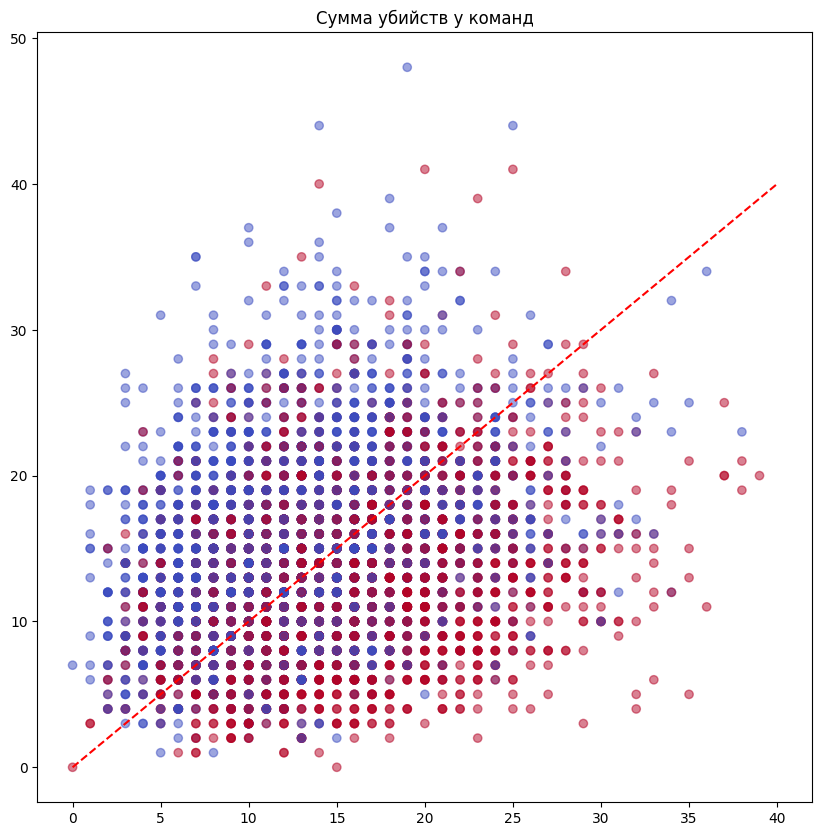

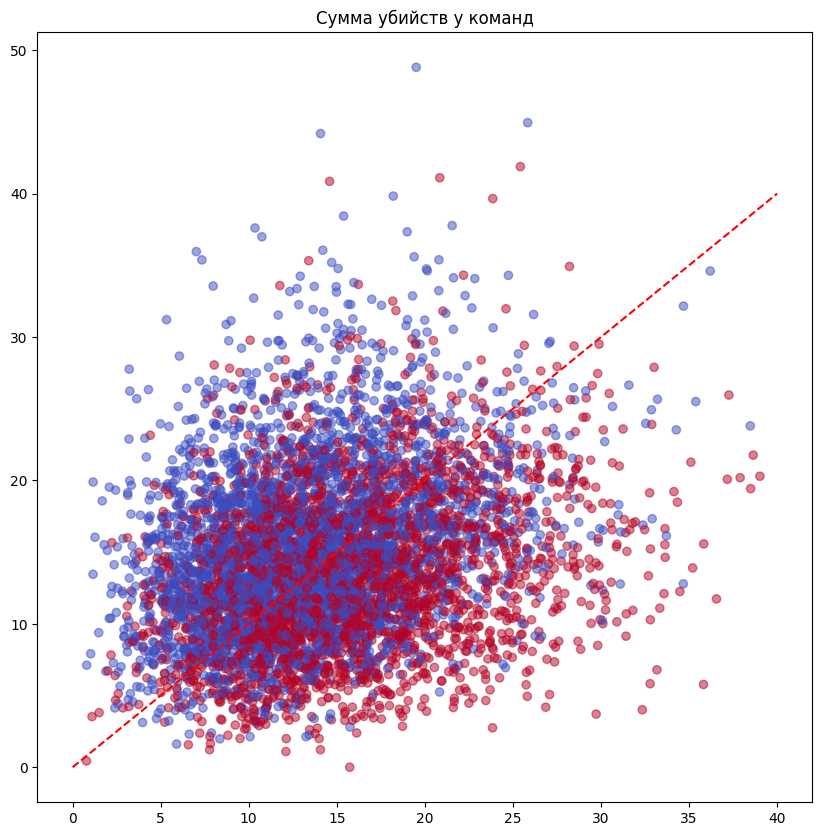

Можно заметить, что разница в убийствах влияет на победу команды


In [178]:
# Посмотрим на распределение суммы убийств у команд

plt.figure(figsize=(10, 10))
plt.title('Сумма убийств у команд')
plt.scatter(X_train['sum_kills_log_radiant_1200'], X_train['sum_kills_log_dire_1200'], c=y_train, cmap='coolwarm', alpha=0.5);
plt.plot([0, 40], [0, 40], color='red', linestyle='--', label='y=x')
plt.show()

plt.figure(figsize=(10, 10))
plt.title('Сумма убийств у команд')
plt.scatter(np.random.rand(X_train.shape[0]) + X_train['sum_kills_log_radiant_1200'], X_train['sum_kills_log_dire_1200'] + np.random.rand(X_train.shape[0]), c=y_train, cmap='coolwarm', alpha=0.5);
plt.plot([0, 40], [0, 40], color='red', linestyle='--', label='y=x')
plt.show()

print("Можно заметить, что разница в убийствах влияет на победу команды")




Попробуем обучить модель

In [186]:
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

model = CatBoostClassifier(iterations=10, verbose=200, random_state=42, eval_metric='Accuracy', task_type='GPU')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]



Learning rate set to 0.5
0:	learn: 0.6622041	total: 11.5ms	remaining: 103ms
9:	learn: 0.7160816	total: 115ms	remaining: 0us


In [187]:
print(f'Train Accuracy: {accuracy_score(y_train, model.predict(X_train))}')
print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')

print(f'Train ROC-AUC: {roc_auc_score(y_train, model.predict(X_train))}')
print(f'Test ROC-AUC: {roc_auc_score(y_test, y_pred_proba)}')

Train Accuracy: 0.7160816326530612
Test Accuracy: 0.6566579634464752
Train ROC-AUC: 0.7151953770267483
Test ROC-AUC: 0.7132021571795764
